In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))

def get_index(tp):
    if len(tp) == 1:
        return all_types.index(tp[0]), len(all_types)
    return all_types.index(tp[0]), all_types.index(tp[1])

types = torch.tensor([get_index(t) for t in types], device=device)

contour = load_contour().to(device)
contour.shape

torch.Size([3, 386, 1, 64, 64])

In [2]:
T = 500
beta = torch.linspace(0.004, 0.03, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0002, device='cuda:0')

In [3]:
alpha_

tensor([9.9600e-01, 9.9196e-01, 9.8789e-01, 9.8379e-01, 9.7965e-01, 9.7547e-01,
        9.7127e-01, 9.6703e-01, 9.6276e-01, 9.5845e-01, 9.5412e-01, 9.4976e-01,
        9.4536e-01, 9.4094e-01, 9.3649e-01, 9.3201e-01, 9.2751e-01, 9.2298e-01,
        9.1842e-01, 9.1384e-01, 9.0923e-01, 9.0460e-01, 8.9994e-01, 8.9526e-01,
        8.9056e-01, 8.8584e-01, 8.8110e-01, 8.7633e-01, 8.7155e-01, 8.6675e-01,
        8.6192e-01, 8.5708e-01, 8.5223e-01, 8.4735e-01, 8.4246e-01, 8.3756e-01,
        8.3264e-01, 8.2770e-01, 8.2275e-01, 8.1779e-01, 8.1281e-01, 8.0782e-01,
        8.0282e-01, 7.9781e-01, 7.9279e-01, 7.8776e-01, 7.8273e-01, 7.7768e-01,
        7.7262e-01, 7.6756e-01, 7.6249e-01, 7.5741e-01, 7.5233e-01, 7.4724e-01,
        7.4215e-01, 7.3706e-01, 7.3196e-01, 7.2686e-01, 7.2175e-01, 7.1665e-01,
        7.1154e-01, 7.0643e-01, 7.0132e-01, 6.9622e-01, 6.9111e-01, 6.8601e-01,
        6.8090e-01, 6.7580e-01, 6.7070e-01, 6.6561e-01, 6.6052e-01, 6.5543e-01,
        6.5035e-01, 6.4528e-01, 6.4021e-

torch.Size([4, 3, 72, 72])


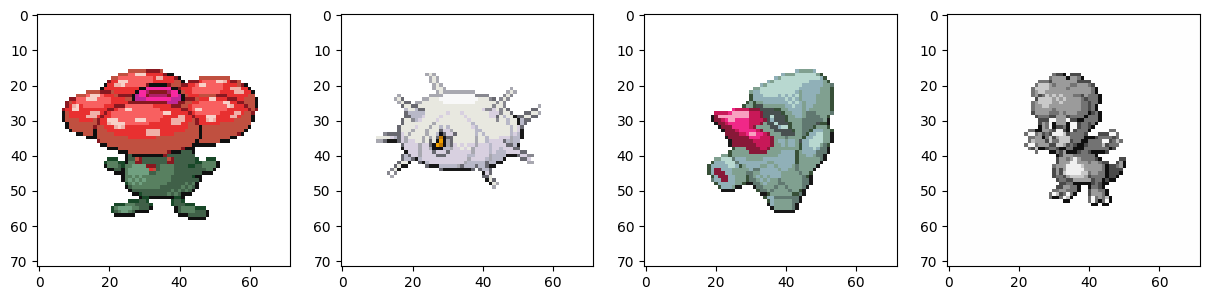

In [4]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #Sobel(),

])
col_transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], .3),
    v2.RandomApply([v2.RandomChannelPermutation()], .3),
    v2.RandomGrayscale(p = .3),
])

source = torch.randint(0, 2, (4,))
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
print(x0.shape)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)

In [6]:
@torch.no_grad
def generate_image():
    global model
    model.eval()

    N = 3
    
    #A = torch.tensor([300, 300, 300], device=device)
    #x0 = pimages[1, [0,151,251]]
    #x0 = torch.stack([transform(x) for x in x0], dim=0)
    #x0 = isigmoid(x0)
    #z = torch.randn_like(x0)
    #x = torch.sqrt(alpha_[A])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[A])[:, None, None, None] * z

    x = torch.randn((N, 3, 72, 72), device=device)
    
    ty = [["Dark"], ["Fairy"], ["Electric"]]
    ty = torch.tensor([get_index(t) for t in ty], device=device)
    c = contour[0, [0, 151, 251]]
    c = torch.stack([pos_transform(d) for d in c], dim=0)
    
    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty, c) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])

        #clear_output(wait=True)
        #fig, axes = plt.subplots(1, N, figsize=(10, 10))
        #for i in range(N):
        #    plot_image(torch.sigmoid(x-e)[i], axes[i])
        #plt.show()

    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

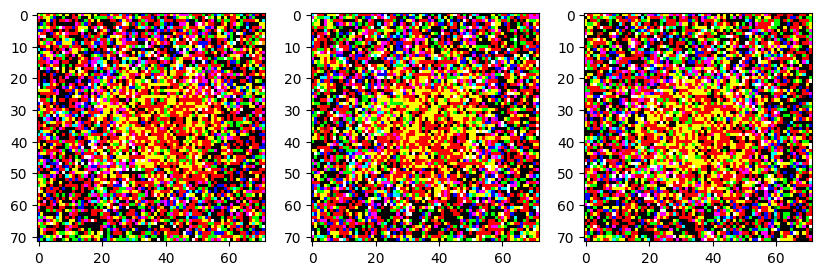

0.05934569:   1%|          | 1000/100001 [00:42<1:06:19, 24.88it/s]

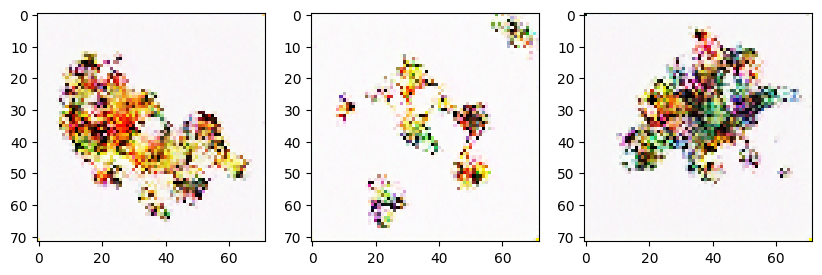

0.04557007:   2%|▏         | 1999/100001 [01:25<1:05:52, 24.80it/s]

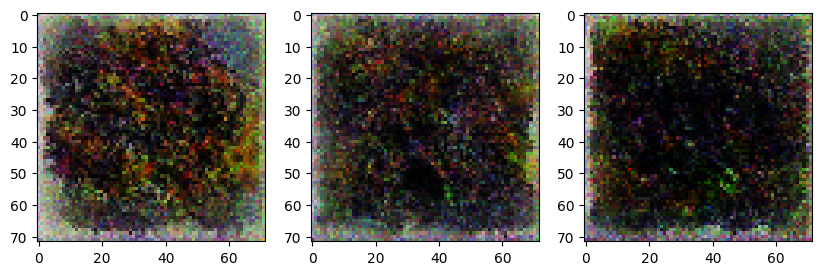

0.03606793:   3%|▎         | 2998/100001 [02:08<1:05:09, 24.81it/s]

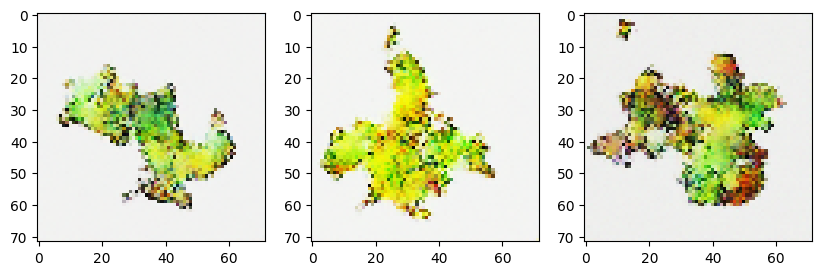

0.03723736:   4%|▍         | 4000/100001 [02:50<1:04:29, 24.81it/s]

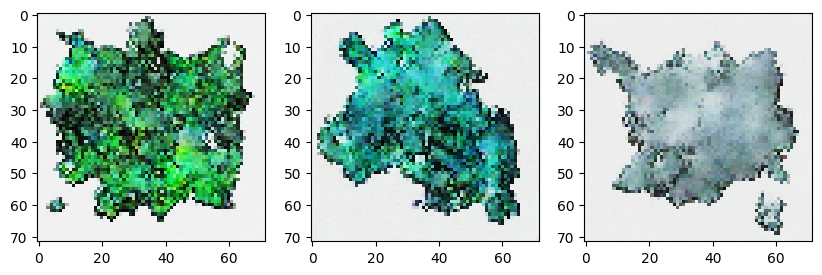

0.04592581:   5%|▍         | 4999/100001 [03:33<1:03:39, 24.87it/s]

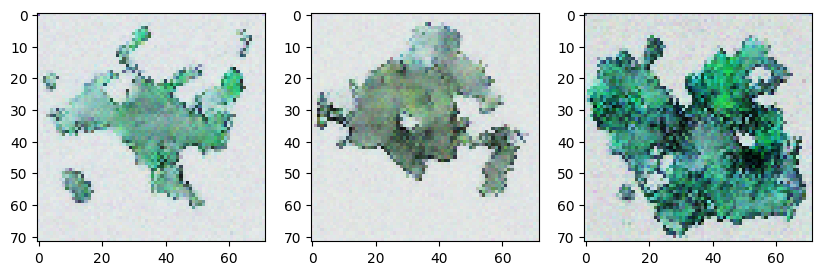

0.03056793:   6%|▌         | 5998/100001 [04:16<1:02:52, 24.92it/s]

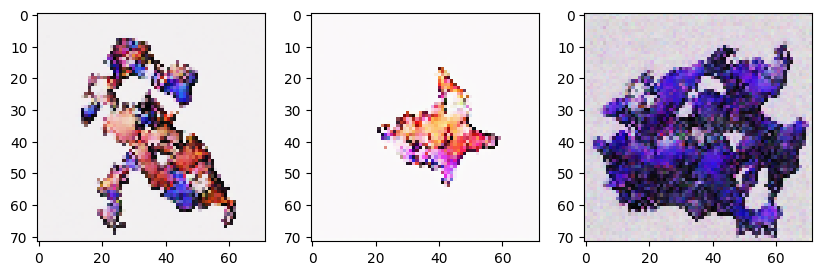

0.02719382:   7%|▋         | 7000/100001 [04:58<1:02:29, 24.80it/s]

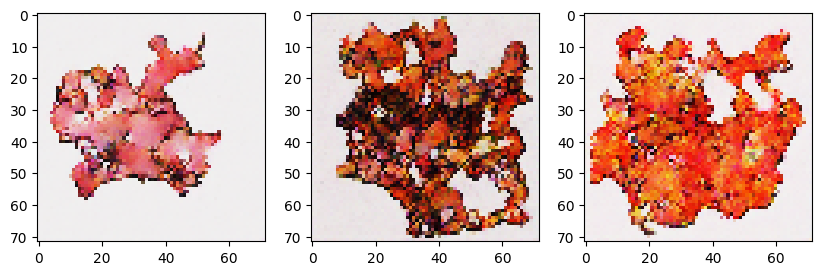

0.04678700:   8%|▊         | 7999/100001 [05:41<1:01:40, 24.86it/s]

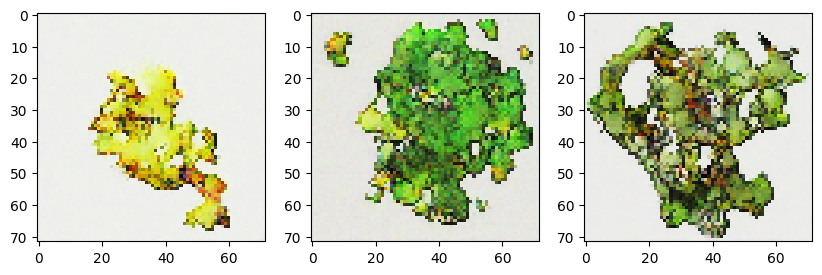

0.03251211:   9%|▉         | 8998/100001 [06:23<1:01:07, 24.82it/s]

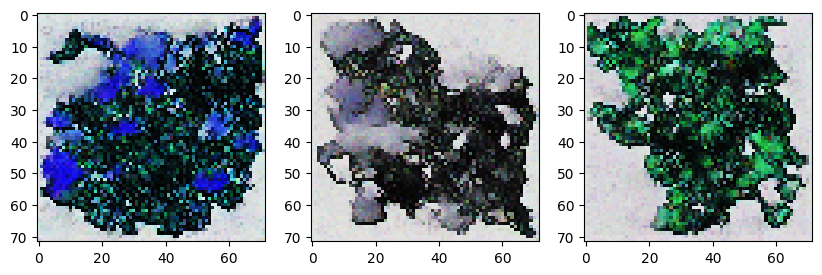

0.03386463:  10%|▉         | 10000/100001 [07:06<1:00:10, 24.93it/s]

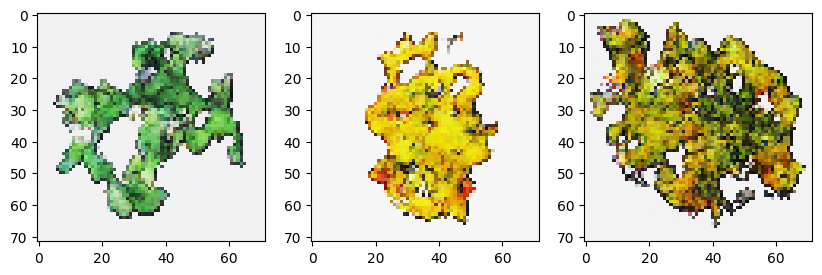

0.02946129:  11%|█         | 10999/100001 [07:49<59:28, 24.94it/s]  

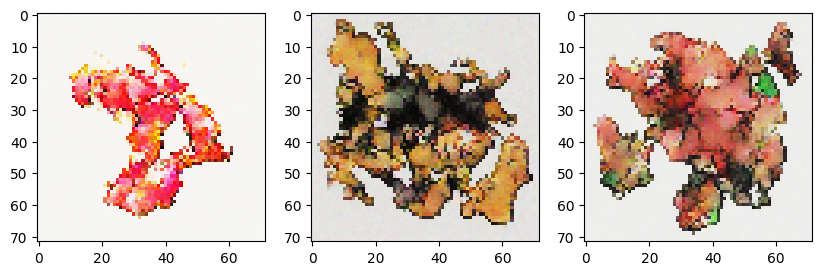

0.02558958:  12%|█▏        | 11998/100001 [08:31<58:57, 24.88it/s]  

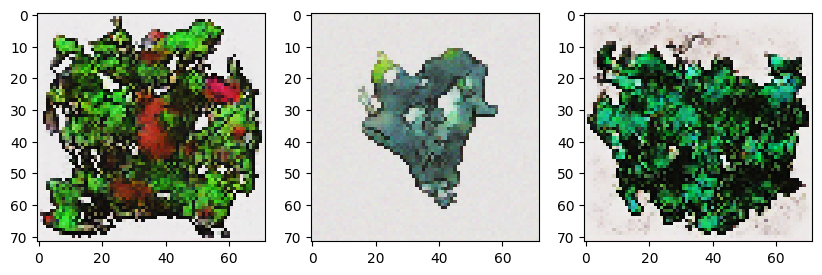

0.03348438:  13%|█▎        | 13000/100001 [09:14<58:16, 24.88it/s]  

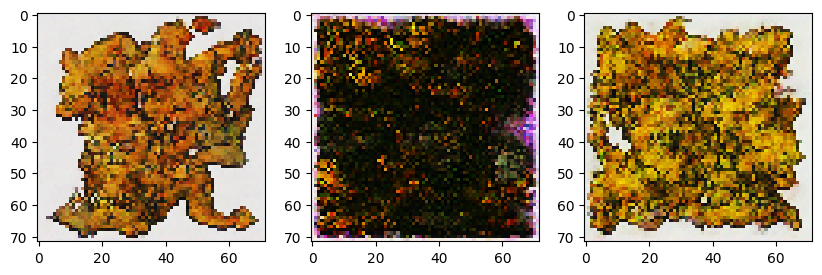

0.04398539:  14%|█▍        | 13999/100001 [09:57<57:46, 24.81it/s]  

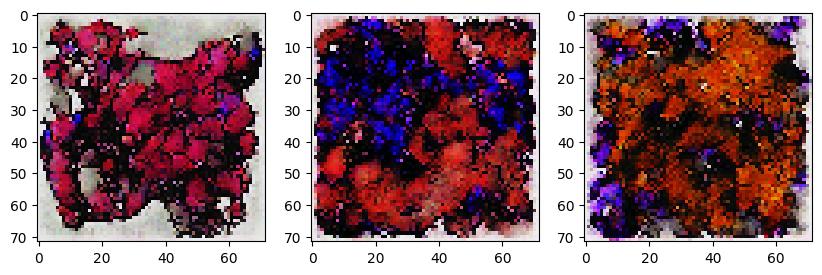

0.03953094:  15%|█▍        | 14998/100001 [10:39<56:58, 24.86it/s]  

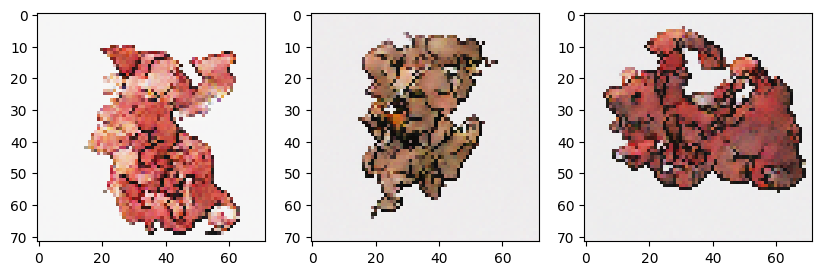

0.01860307:  16%|█▌        | 16000/100001 [11:22<56:08, 24.94it/s]  

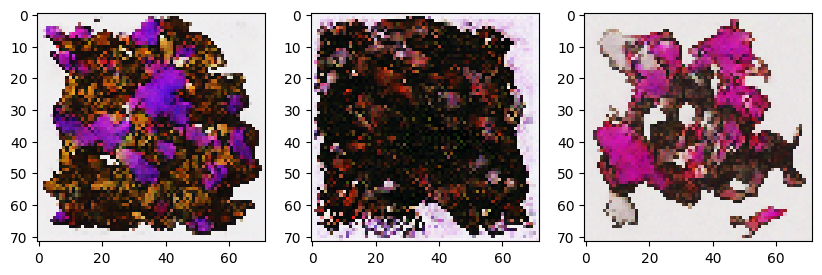

0.03740281:  17%|█▋        | 16999/100001 [12:05<55:32, 24.90it/s]  

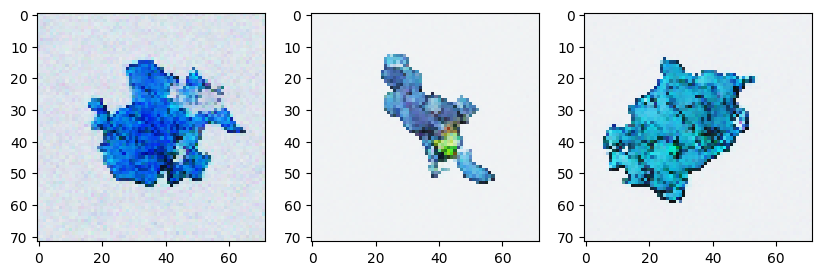

0.02530397:  18%|█▊        | 17998/100001 [12:47<55:03, 24.83it/s]  

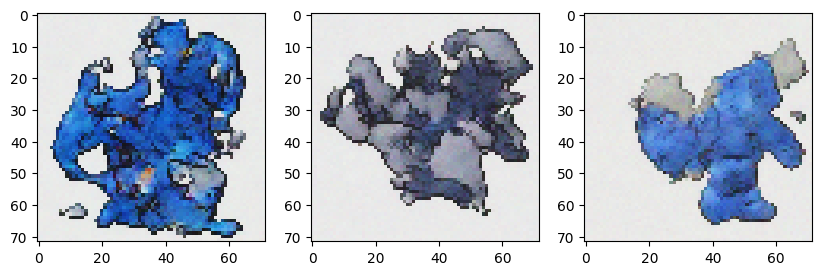

0.02795596:  19%|█▉        | 19000/100001 [13:30<54:24, 24.81it/s]  

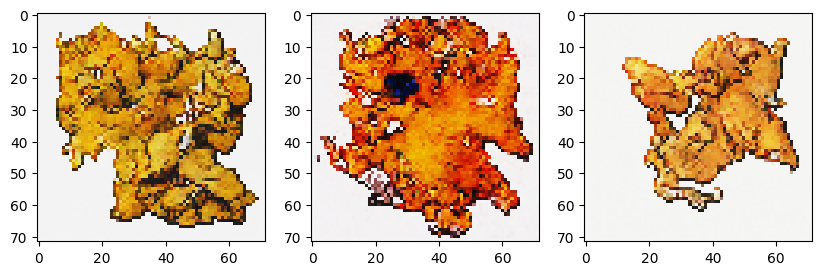

0.03400783:  20%|█▉        | 19999/100001 [14:13<53:39, 24.85it/s]  

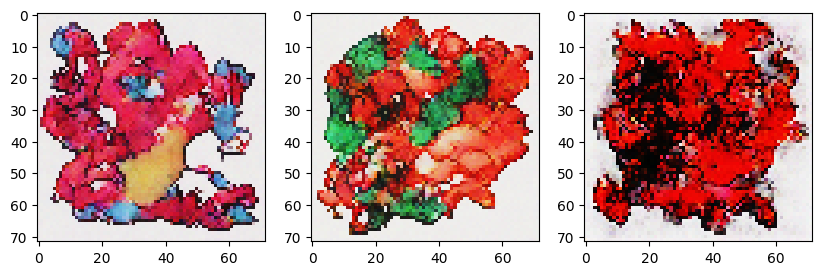

0.03494092:  21%|██        | 20998/100001 [14:55<53:03, 24.82it/s]  

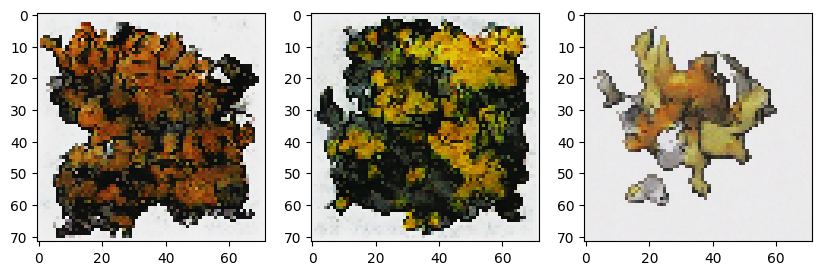

0.03297271:  22%|██▏       | 22000/100001 [15:38<52:25, 24.80it/s]  

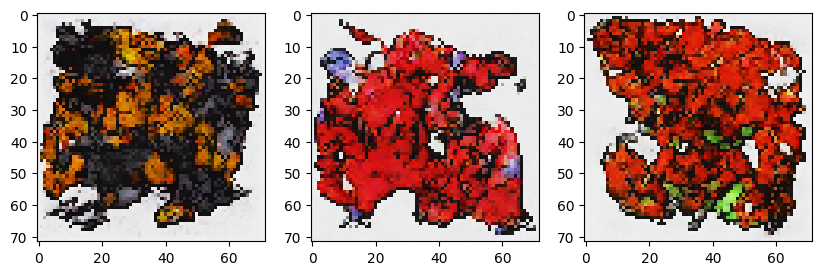

0.02631791:  23%|██▎       | 22999/100001 [16:21<51:37, 24.86it/s]  

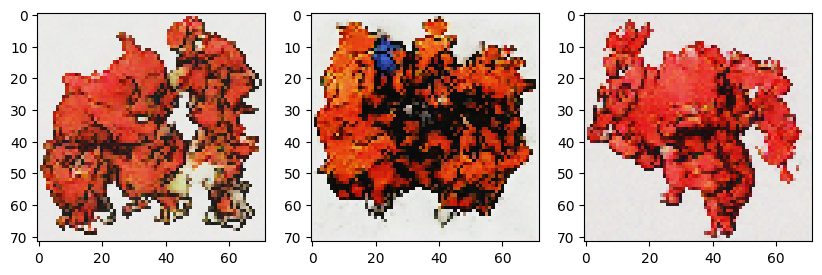

0.02566878:  24%|██▍       | 23998/100001 [17:03<51:00, 24.83it/s]  

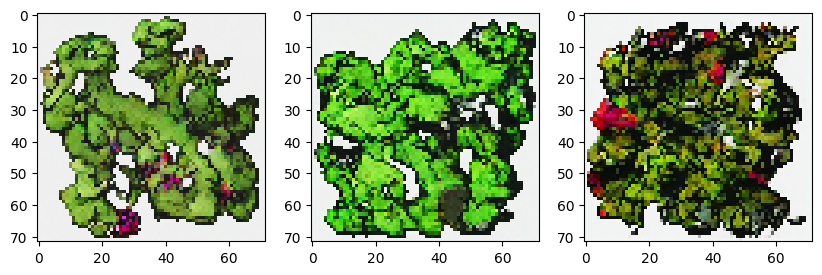

0.02508445:  25%|██▍       | 25000/100001 [17:46<50:22, 24.81it/s]  

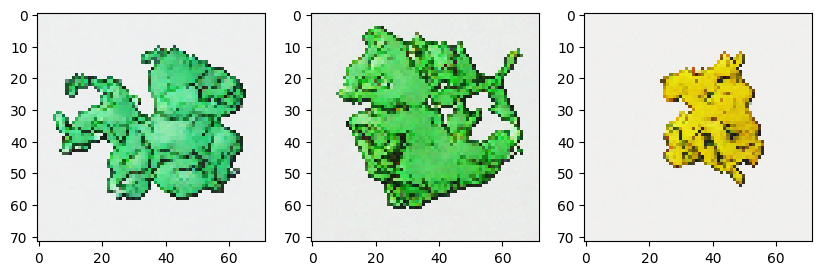

0.02966093:  26%|██▌       | 25999/100001 [18:29<49:36, 24.86it/s]  

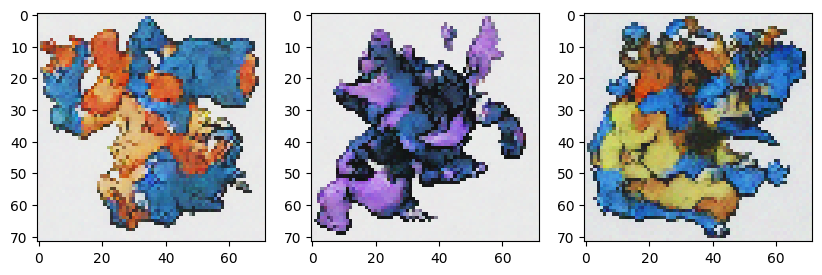

0.02567729:  27%|██▋       | 26998/100001 [19:11<48:37, 25.03it/s]  

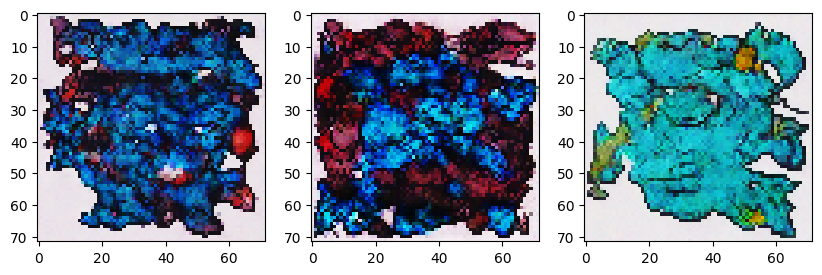

0.01187357:  28%|██▊       | 28000/100001 [19:54<48:13, 24.88it/s]  

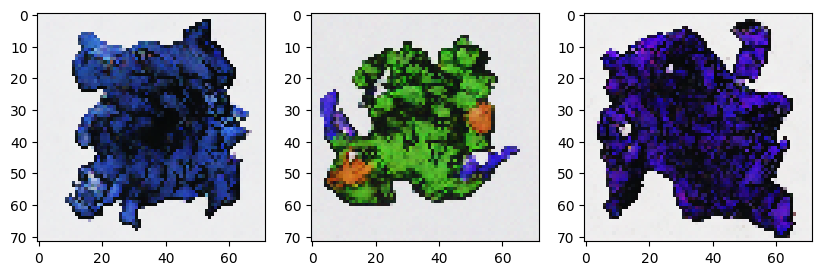

0.01607807:  29%|██▉       | 28999/100001 [20:37<47:29, 24.92it/s]  

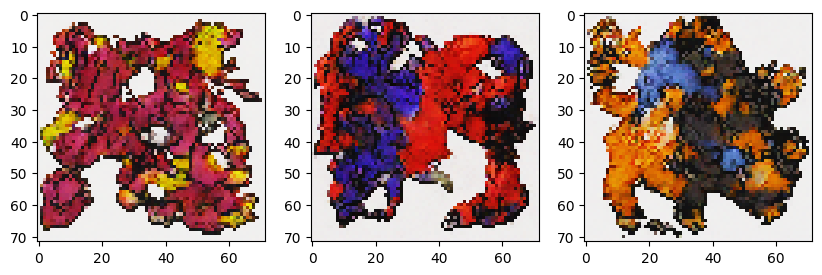

0.02959115:  30%|██▉       | 29998/100001 [21:19<46:59, 24.83it/s]  

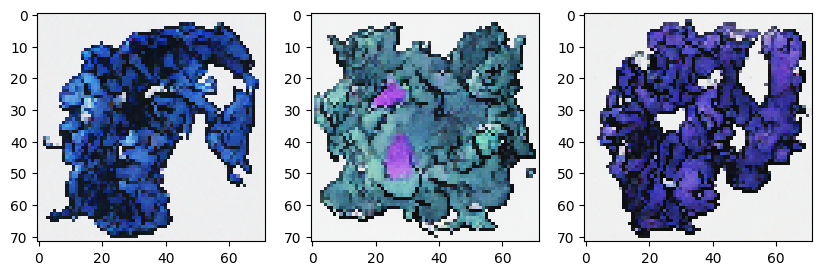

0.02181451:  31%|███       | 31000/100001 [22:02<46:16, 24.85it/s]  

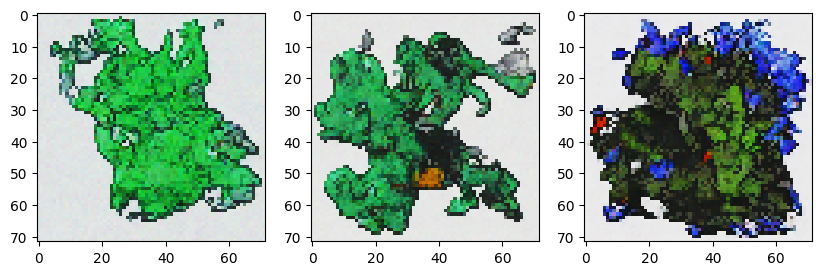

0.02408103:  32%|███▏      | 31999/100001 [22:45<45:41, 24.81it/s]  

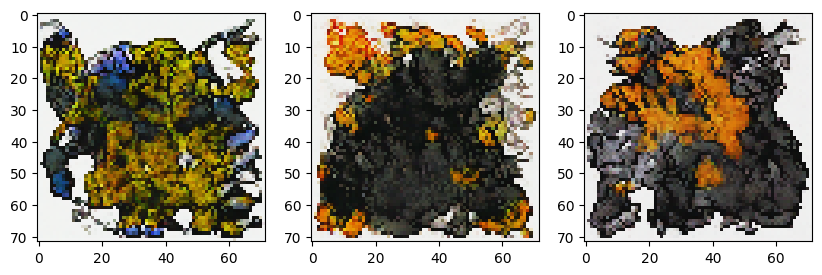

0.01814328:  33%|███▎      | 32998/100001 [23:27<44:56, 24.85it/s]  

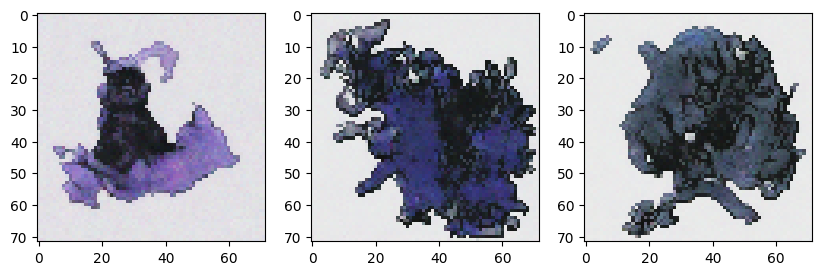

0.02969852:  34%|███▍      | 34000/100001 [24:10<44:14, 24.86it/s]  

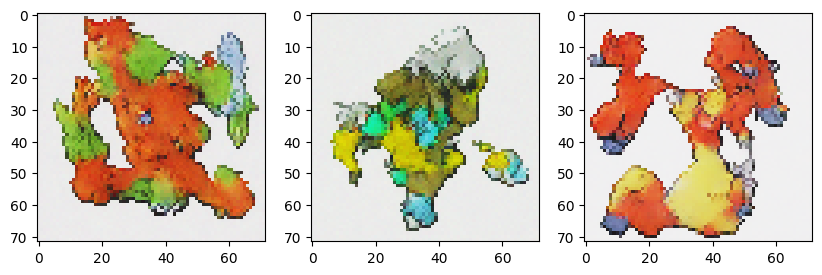

0.01828602:  35%|███▍      | 34999/100001 [24:53<43:25, 24.94it/s]  

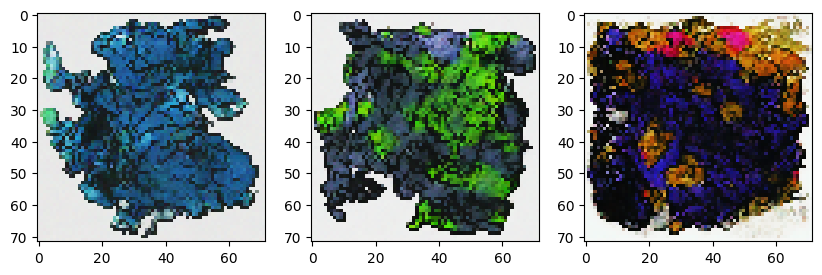

0.03919812:  36%|███▌      | 35998/100001 [25:35<42:53, 24.87it/s]  

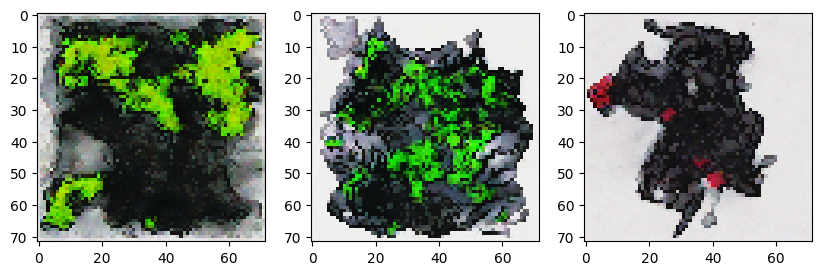

0.01865491:  37%|███▋      | 37000/100001 [26:18<42:15, 24.85it/s]  

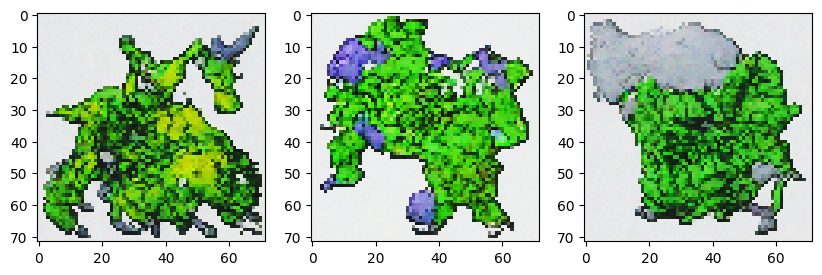

0.01732621:  38%|███▊      | 37999/100001 [27:00<41:22, 24.98it/s]  

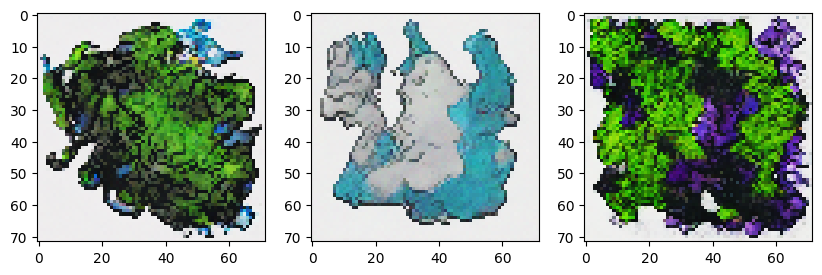

0.02668634:  39%|███▉      | 38998/100001 [27:43<40:54, 24.86it/s]  

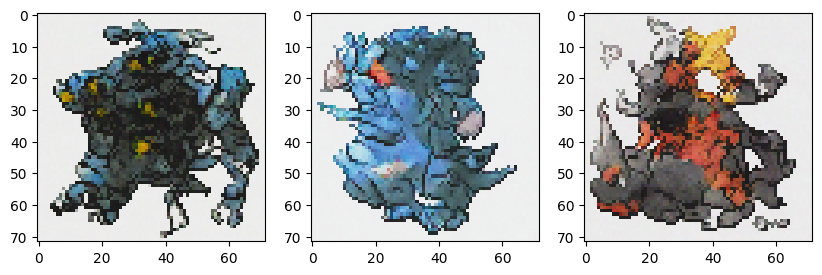

0.02573709:  40%|███▉      | 40000/100001 [28:26<40:11, 24.88it/s]  

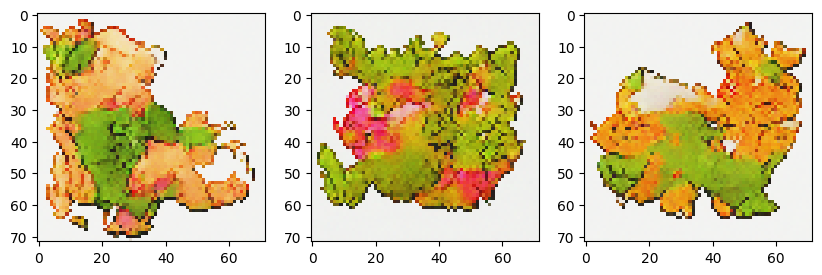

0.02243454:  41%|████      | 40999/100001 [29:08<39:41, 24.77it/s]  

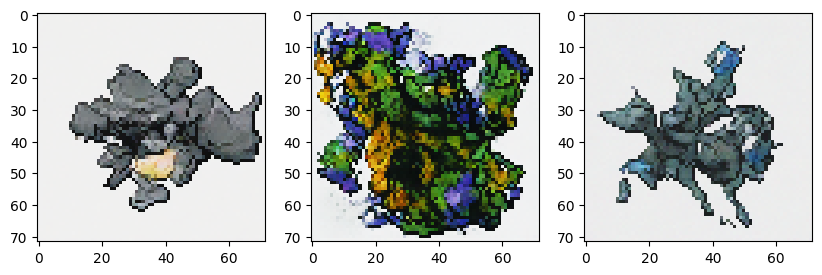

0.02003893:  42%|████▏     | 41998/100001 [29:51<38:55, 24.83it/s]  

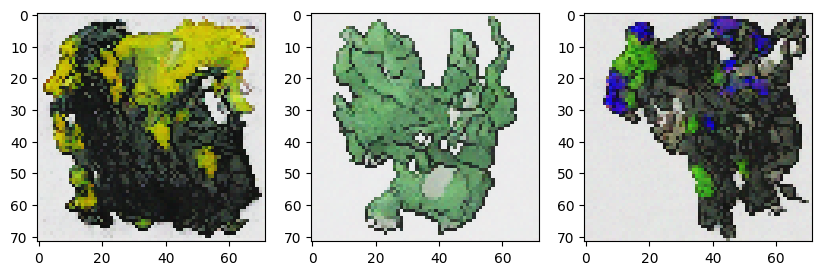

0.03430194:  43%|████▎     | 43000/100001 [30:34<38:09, 24.90it/s]  

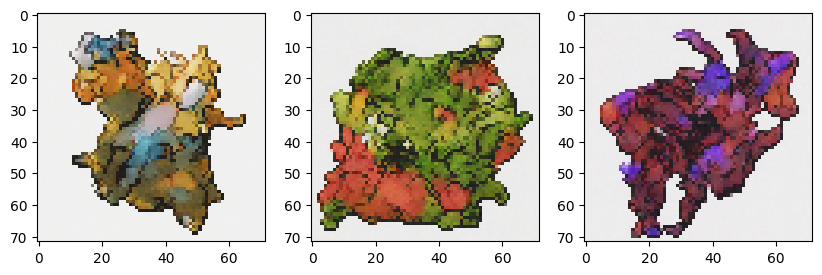

0.02036132:  44%|████▍     | 43999/100001 [31:16<37:24, 24.95it/s]  

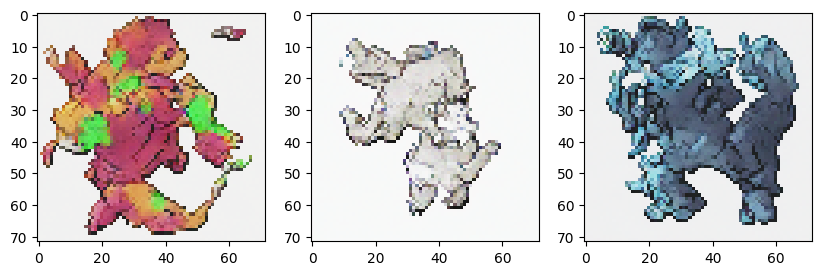

0.01561194:  45%|████▍     | 44998/100001 [31:59<36:52, 24.86it/s]  

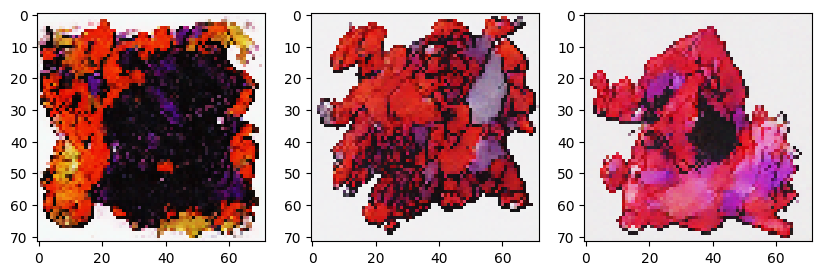

0.01214211:  46%|████▌     | 46000/100001 [32:42<36:10, 24.88it/s]  

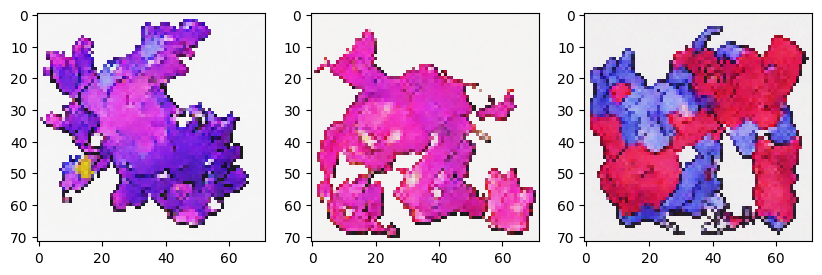

0.01196588:  47%|████▋     | 46999/100001 [33:24<35:36, 24.81it/s]  

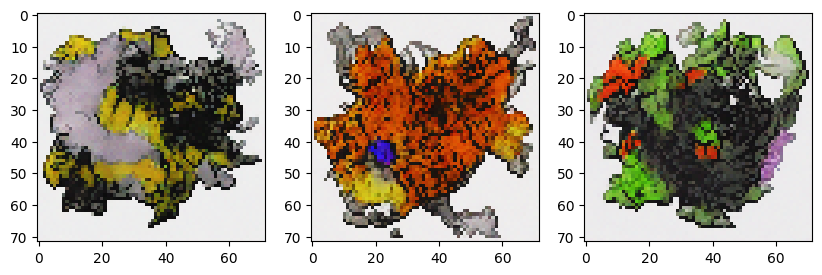

0.02084788:  48%|████▊     | 47998/100001 [34:07<34:55, 24.82it/s]  

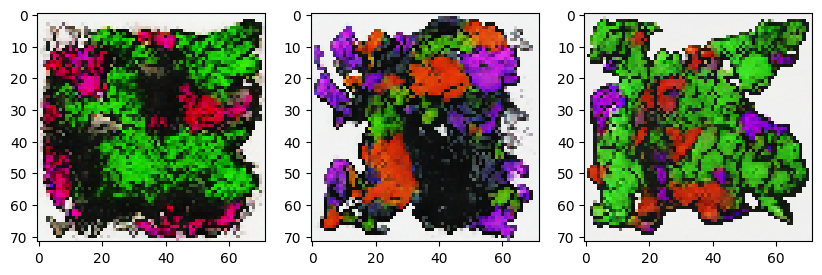

0.03469156:  49%|████▉     | 49000/100001 [34:50<34:09, 24.89it/s]  

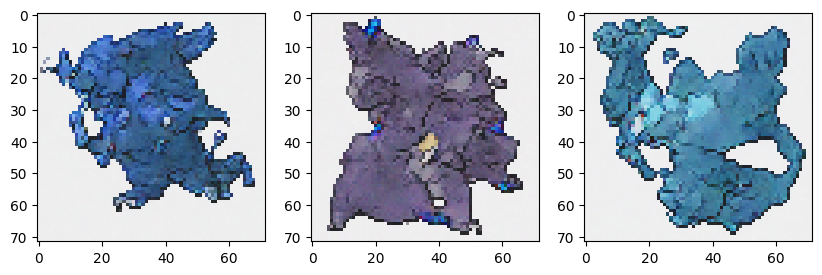

0.02258100:  50%|████▉     | 49999/100001 [35:32<33:35, 24.81it/s]  

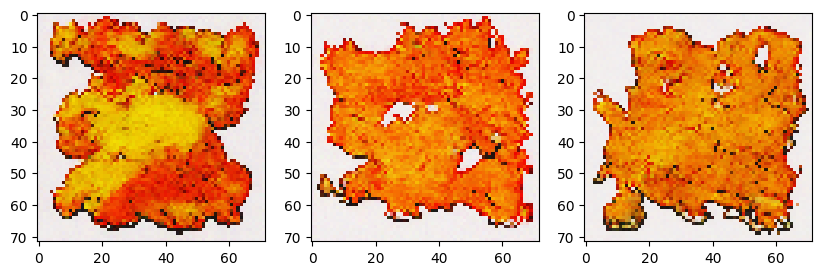

0.01738286:  51%|█████     | 50998/100001 [36:15<32:47, 24.90it/s]  

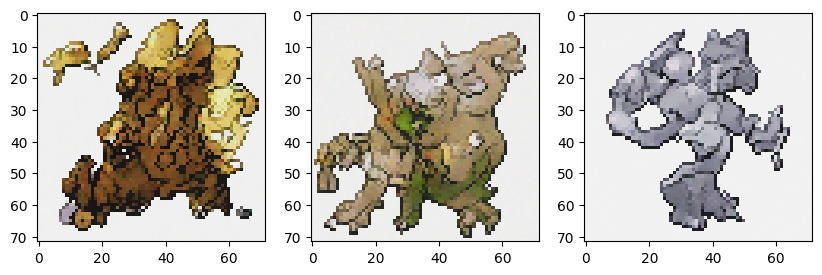

0.01639341:  52%|█████▏    | 52000/100001 [36:58<32:13, 24.83it/s]  

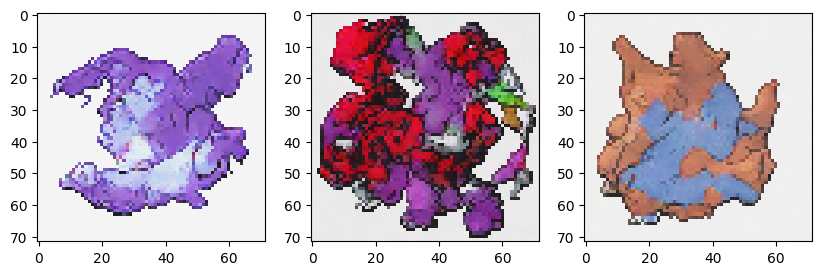

0.02201130:  53%|█████▎    | 52999/100001 [37:40<31:27, 24.90it/s]  

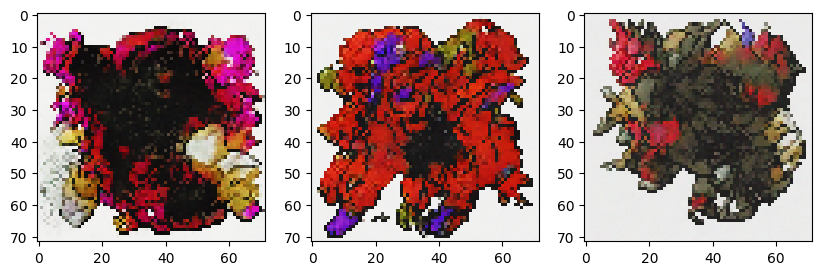

0.01894774:  54%|█████▍    | 53998/100001 [38:23<30:39, 25.00it/s]  

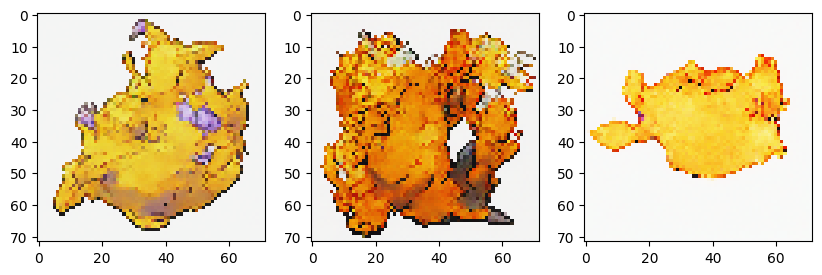

0.02942684:  55%|█████▍    | 55000/100001 [39:05<30:14, 24.80it/s]  

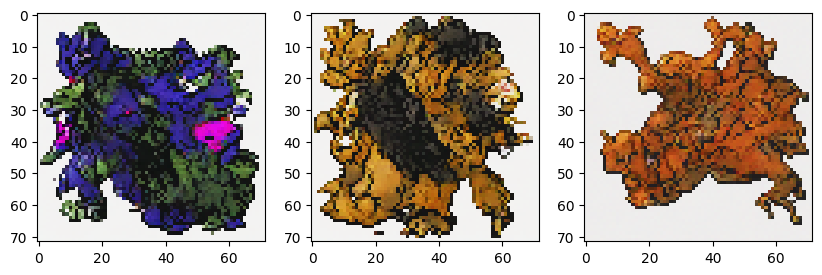

0.01554625:  56%|█████▌    | 55999/100001 [39:48<29:25, 24.92it/s]  

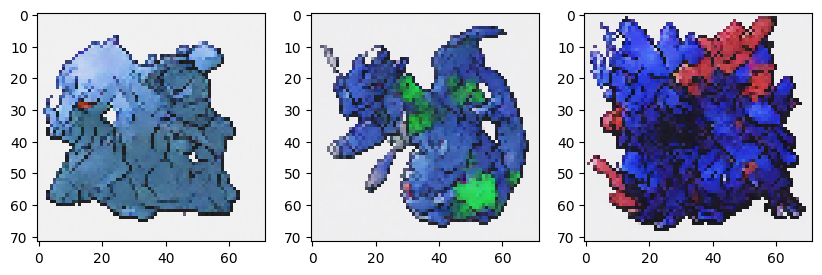

0.02400325:  57%|█████▋    | 56998/100001 [40:31<28:50, 24.86it/s]  

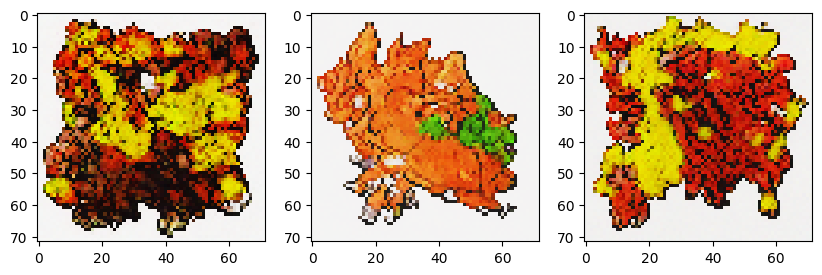

0.02540767:  58%|█████▊    | 58000/100001 [41:13<28:02, 24.97it/s]  

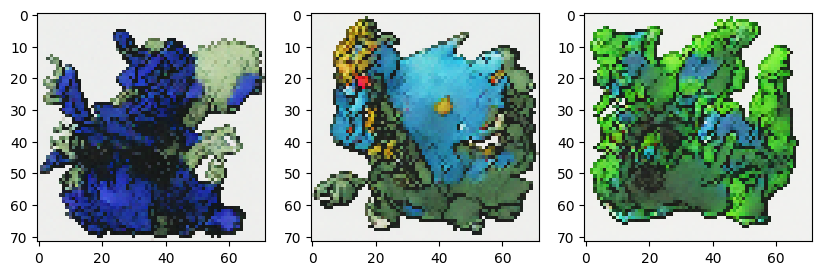

0.02689613:  59%|█████▉    | 58999/100001 [41:56<27:29, 24.85it/s]  

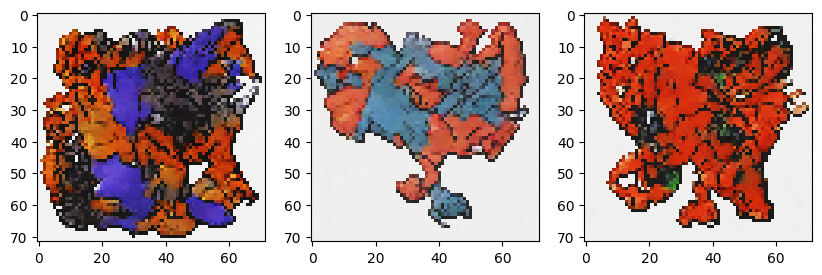

0.01243861:  60%|█████▉    | 59998/100001 [42:39<26:50, 24.84it/s]  

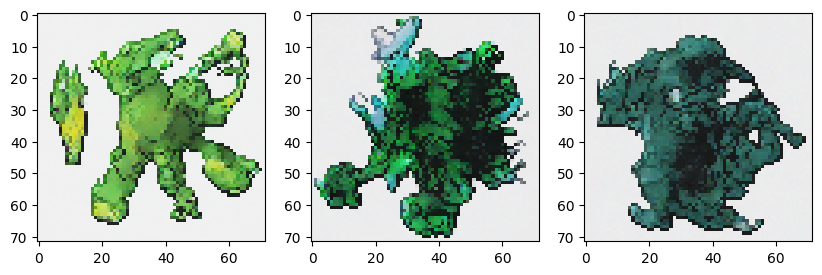

0.02053932:  61%|██████    | 61000/100001 [43:21<26:13, 24.78it/s]  

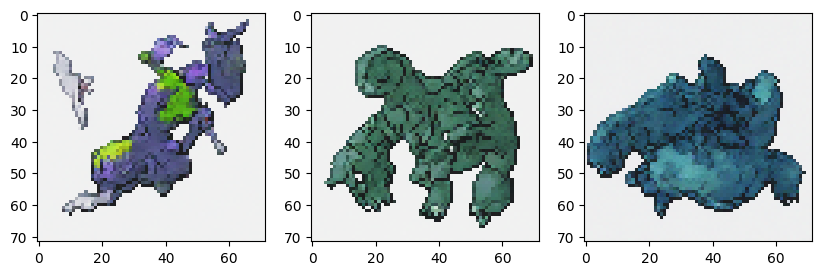

0.03323165:  62%|██████▏   | 61999/100001 [44:04<25:20, 25.00it/s]  

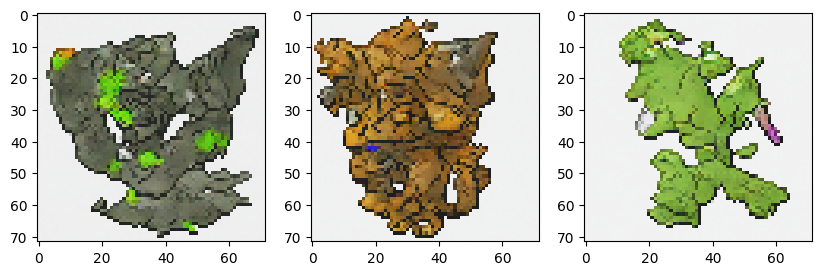

0.01685889:  63%|██████▎   | 62998/100001 [44:46<24:52, 24.80it/s]  

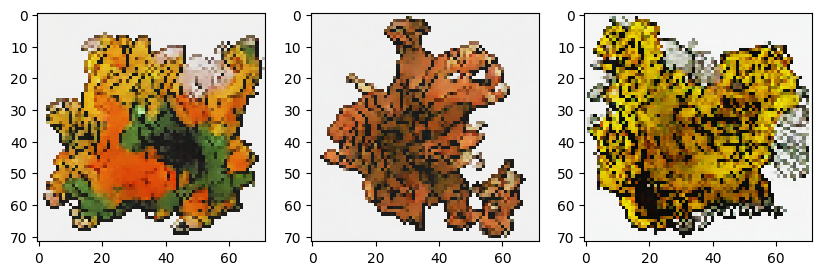

0.02811660:  64%|██████▍   | 64000/100001 [45:29<24:06, 24.89it/s]  

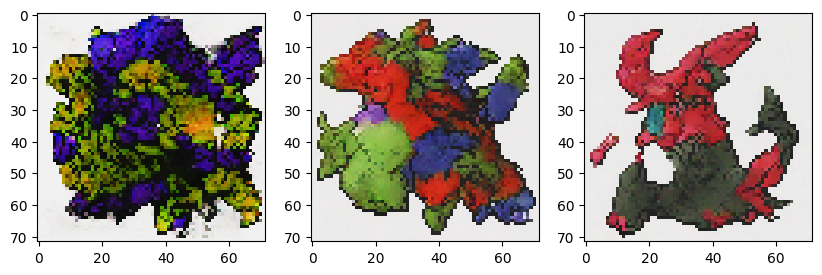

0.01828796:  65%|██████▍   | 64999/100001 [46:12<23:28, 24.85it/s]  

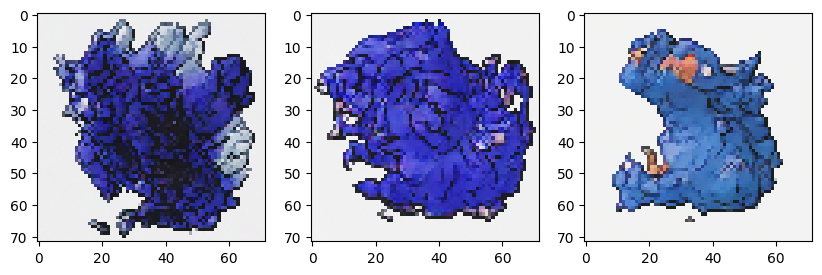

0.02320530:  66%|██████▌   | 65998/100001 [46:55<22:47, 24.87it/s]  

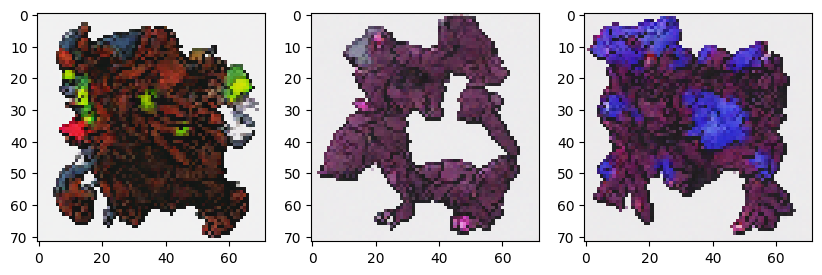

0.02453595:  67%|██████▋   | 67000/100001 [47:37<22:10, 24.81it/s]  

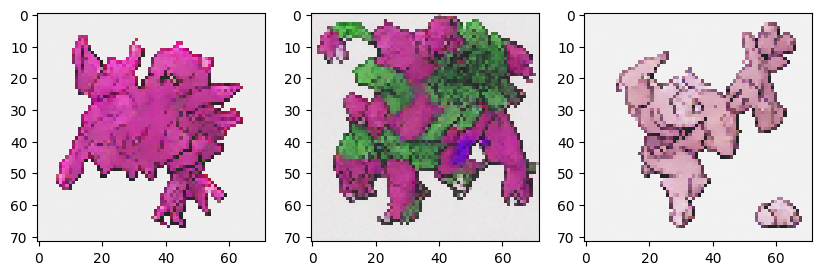

0.01920861:  68%|██████▊   | 67999/100001 [48:20<21:27, 24.85it/s]  

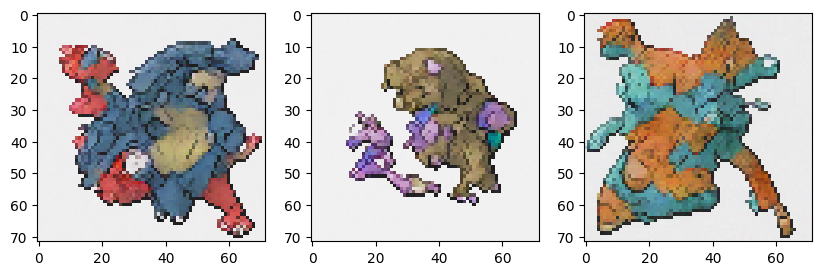

0.02211354:  69%|██████▉   | 68998/100001 [49:03<20:59, 24.61it/s]  

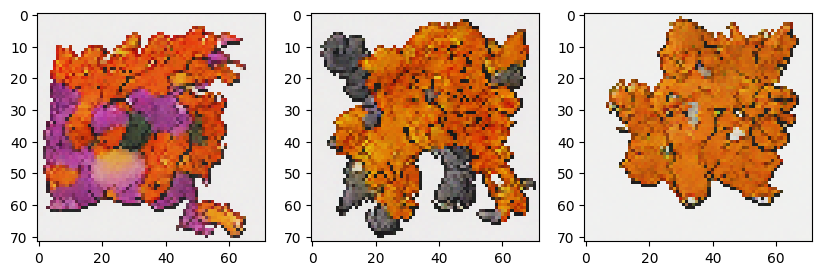

0.02739951:  70%|██████▉   | 70000/100001 [49:45<20:08, 24.83it/s]  

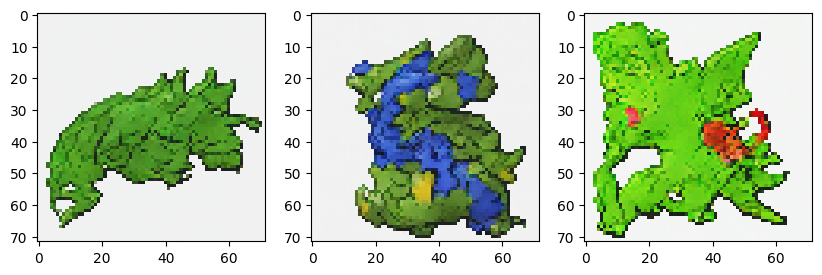

0.01278615:  71%|███████   | 70999/100001 [50:28<19:23, 24.92it/s]  

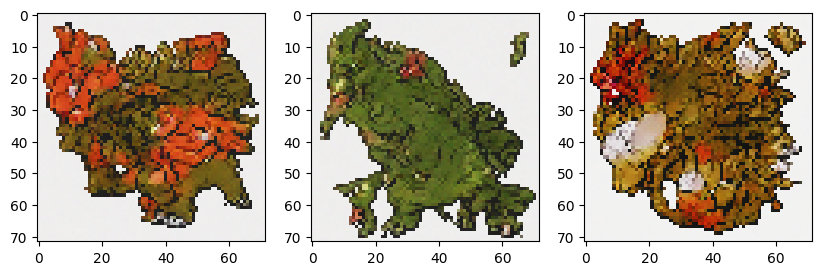

0.04186493:  72%|███████▏  | 71998/100001 [51:11<18:48, 24.82it/s]  

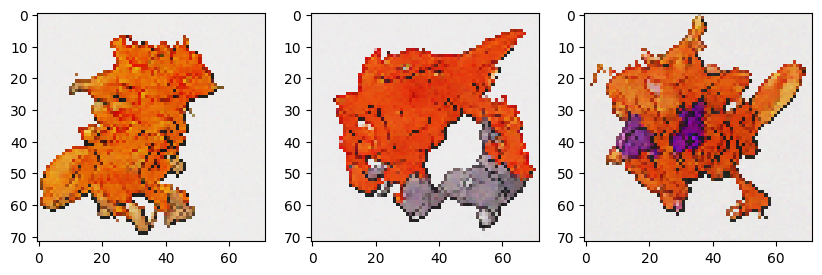

0.02230651:  73%|███████▎  | 73000/100001 [51:53<18:06, 24.84it/s]  

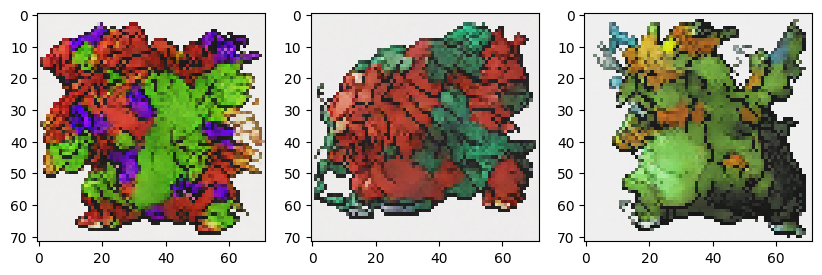

0.01697795:  74%|███████▍  | 73999/100001 [52:36<17:25, 24.87it/s]  

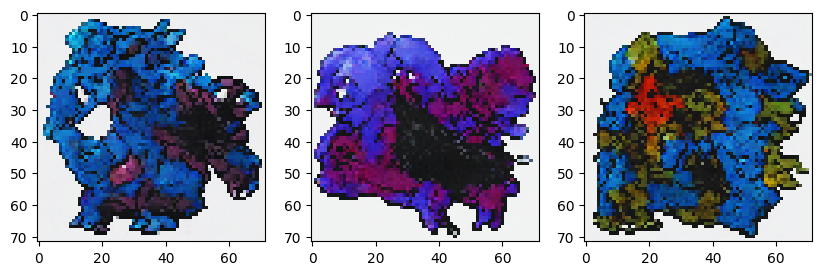

0.01376358:  75%|███████▍  | 74998/100001 [53:18<16:47, 24.81it/s]  

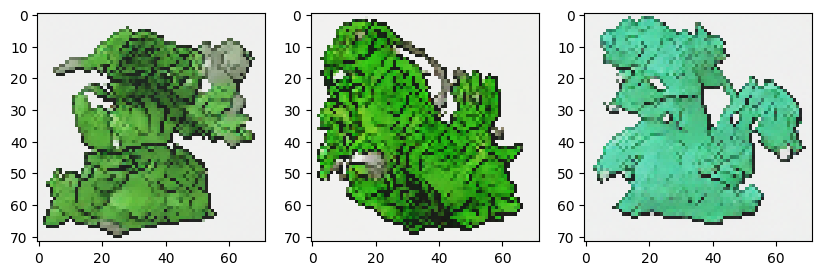

0.01797485:  76%|███████▌  | 76000/100001 [54:01<16:03, 24.92it/s]  

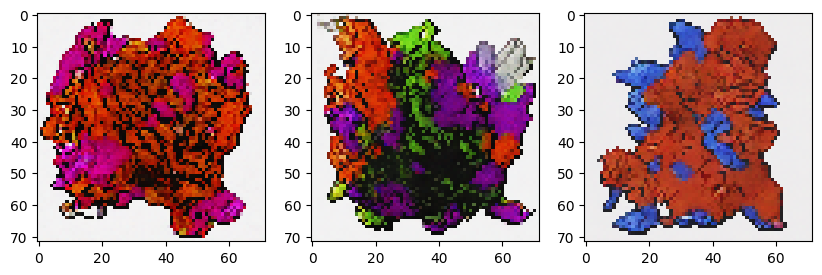

0.02360375:  77%|███████▋  | 76999/100001 [54:44<15:23, 24.90it/s]  

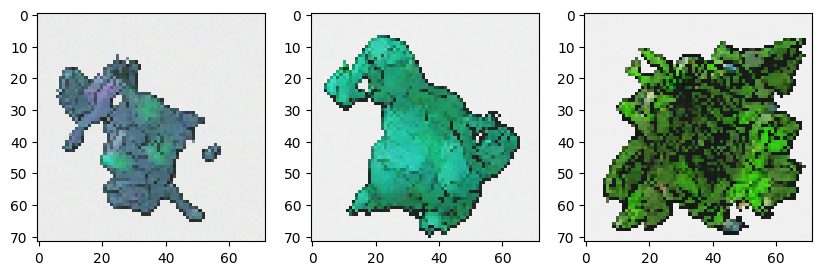

0.03103136:  78%|███████▊  | 77998/100001 [55:26<14:45, 24.86it/s]  

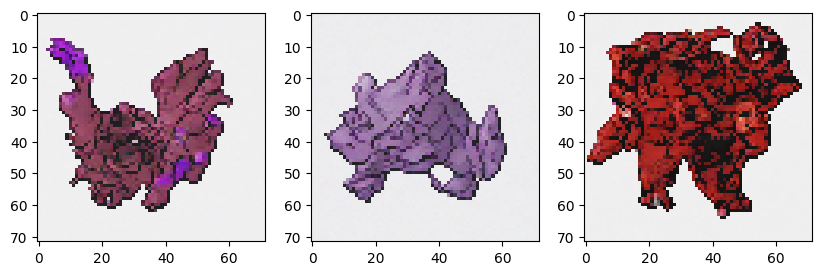

0.01933344:  79%|███████▉  | 79000/100001 [56:09<14:04, 24.87it/s]  

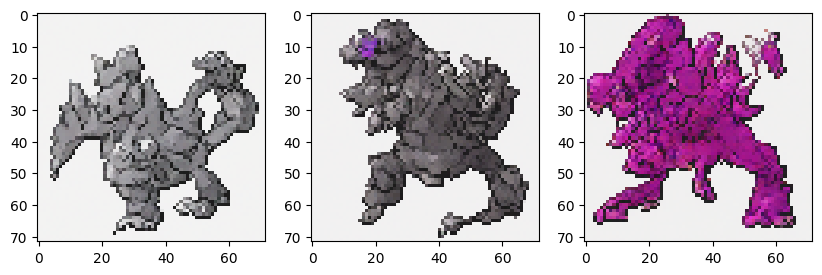

0.02021143:  80%|███████▉  | 79999/100001 [56:52<13:23, 24.91it/s]  

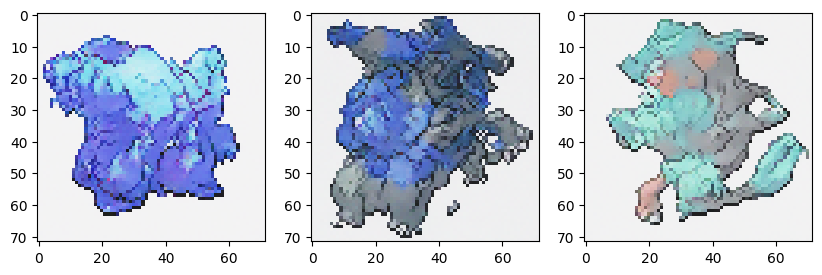

0.02168155:  81%|████████  | 80998/100001 [57:34<12:45, 24.81it/s]  

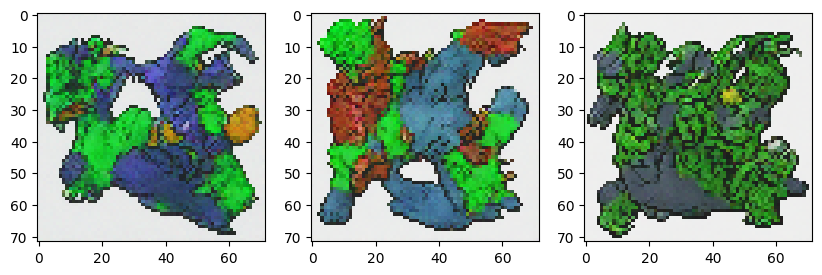

0.02373094:  82%|████████▏ | 82000/100001 [58:17<12:04, 24.86it/s]  

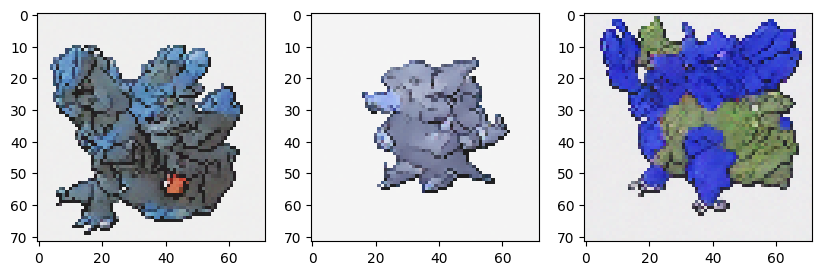

0.02223769:  83%|████████▎ | 82999/100001 [59:00<11:26, 24.78it/s]  

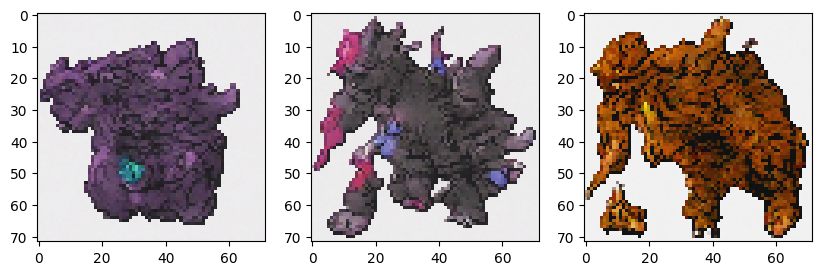

0.02694565:  84%|████████▍ | 83998/100001 [59:42<10:42, 24.90it/s]  

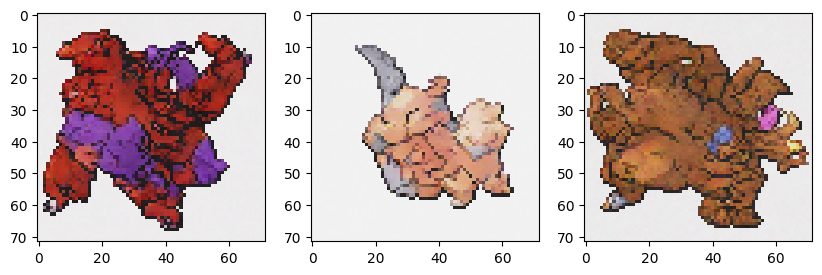

0.03234796:  85%|████████▍ | 85000/100001 [1:00:25<10:03, 24.85it/s]

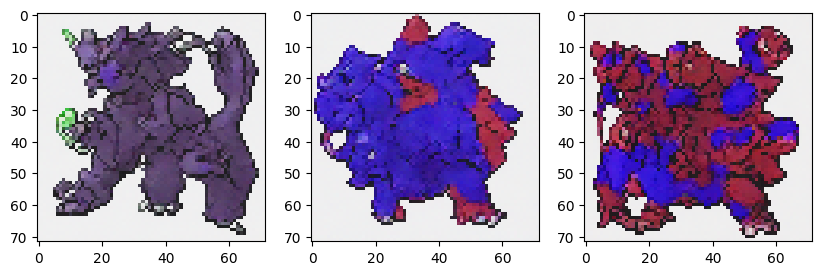

0.01780776:  86%|████████▌ | 85999/100001 [1:01:08<09:23, 24.83it/s]  

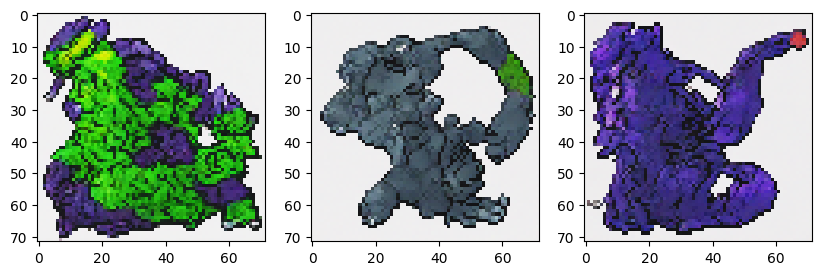

0.01773442:  87%|████████▋ | 86998/100001 [1:01:50<08:42, 24.91it/s]  

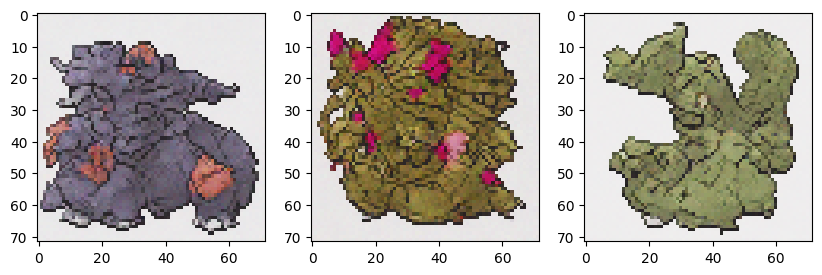

0.02320112:  88%|████████▊ | 88000/100001 [1:02:33<08:04, 24.76it/s]  

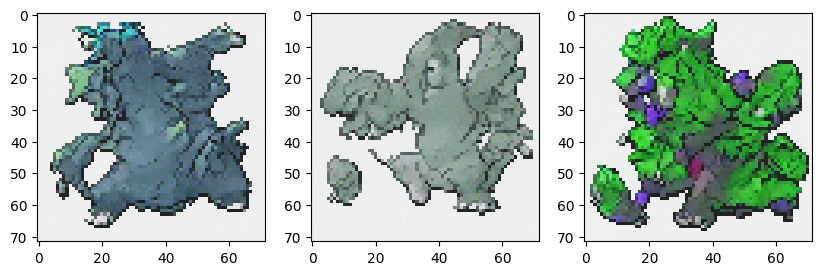

0.01912772:  89%|████████▉ | 88999/100001 [1:03:16<07:21, 24.89it/s]

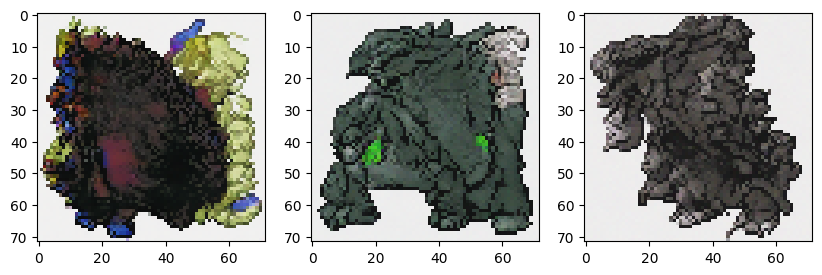

0.01507376:  90%|████████▉ | 89998/100001 [1:03:58<06:43, 24.81it/s]

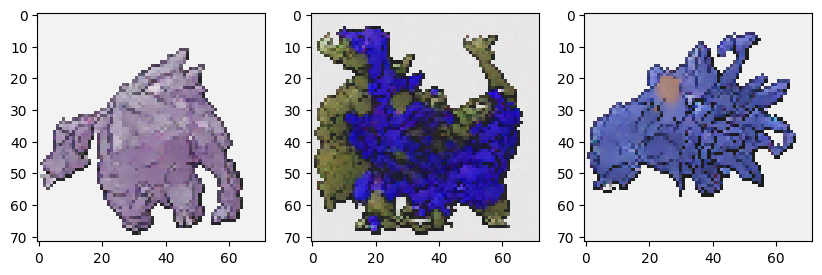

0.01724577:  91%|█████████ | 91000/100001 [1:04:41<06:01, 24.87it/s]

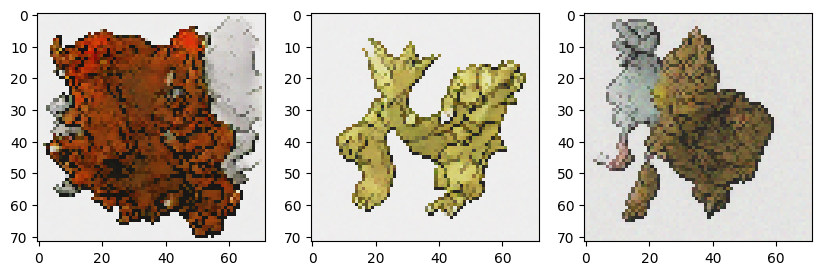

0.01778099:  92%|█████████▏| 91999/100001 [1:05:24<05:22, 24.82it/s]

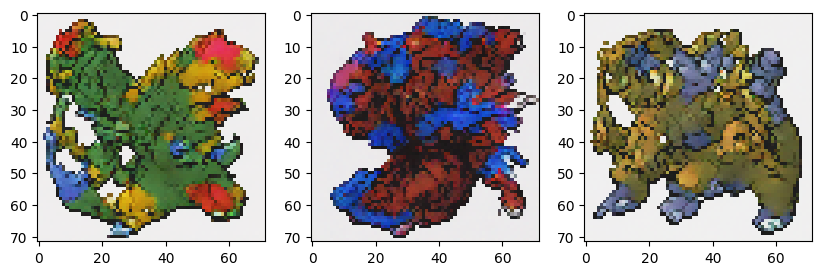

0.01290501:  93%|█████████▎| 92998/100001 [1:06:06<04:41, 24.86it/s]

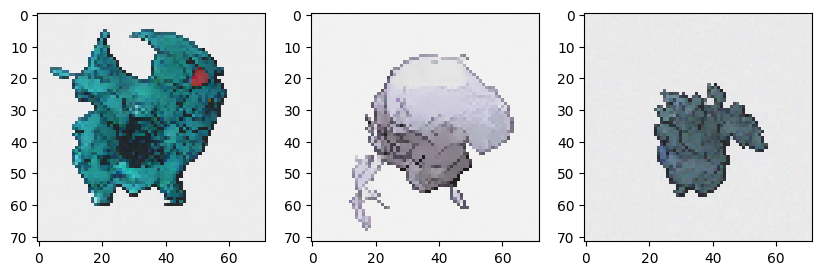

0.01102389:  94%|█████████▍| 94000/100001 [1:06:49<04:02, 24.80it/s]

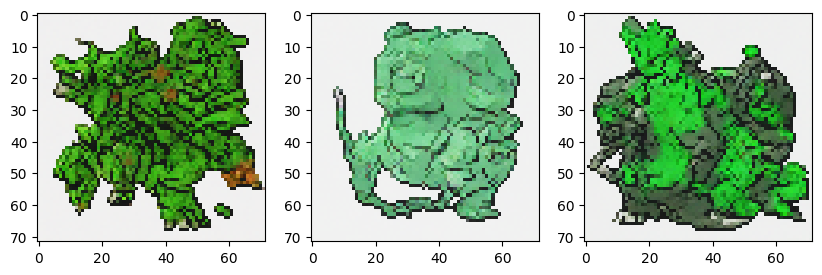

0.01412123:  95%|█████████▍| 94999/100001 [1:07:32<03:21, 24.83it/s]

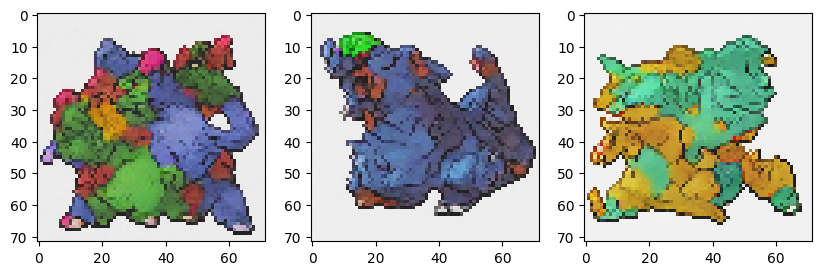

0.02807006:  96%|█████████▌| 95998/100001 [1:08:14<02:41, 24.83it/s]

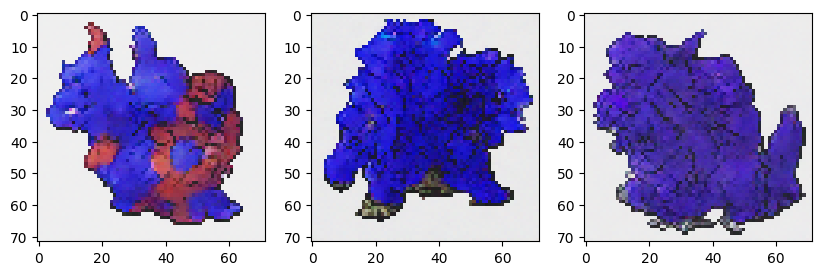

0.03162659:  97%|█████████▋| 97000/100001 [1:08:57<02:00, 24.82it/s]

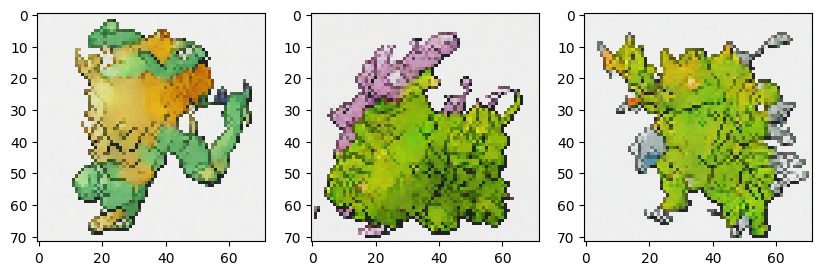

0.02182056:  98%|█████████▊| 97999/100001 [1:09:40<01:20, 24.87it/s]

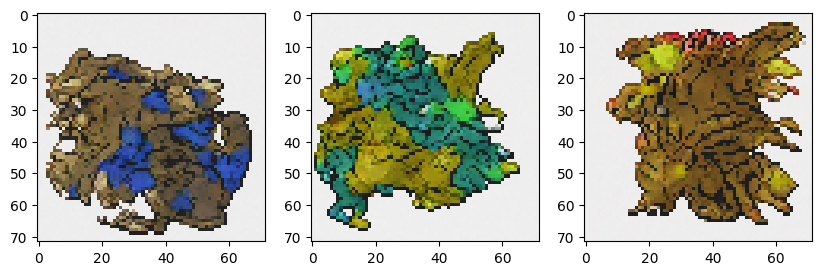

0.01811225:  99%|█████████▉| 98998/100001 [1:10:22<00:40, 24.85it/s]

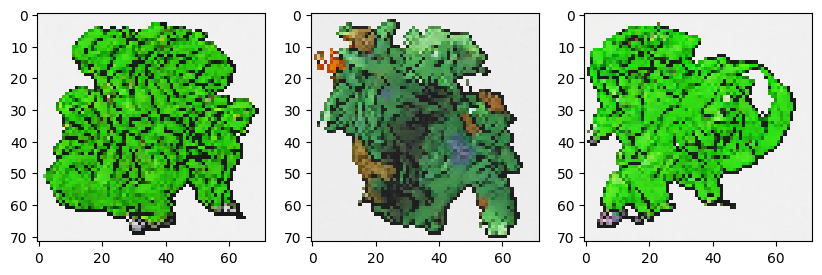

0.01823241: 100%|█████████▉| 100000/100001 [1:11:05<00:00, 24.80it/s]

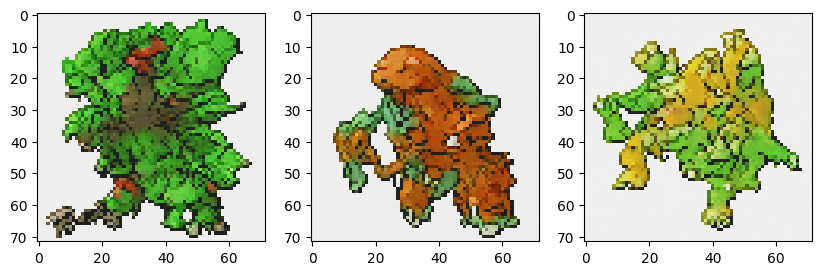

0.01148816: 100%|██████████| 100001/100001 [1:11:08<00:00, 23.43it/s]


In [8]:
model = UNet(3, 3, time_dim=256, num_classes=len(all_types) + 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

loss_func = nn.MSELoss()

pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 16

    source = torch.randint(0, 2, (bs,))
    batch = torch.randperm(385)[:bs]
    
    x0 = pimages[source, batch]
    c = contour[source, batch]

    xc = torch.cat([x0, c], dim=1)
    xc = torch.stack([pos_transform(x) for x in xc], dim=0)
    
    x0 = xc[:, :-1]
    c = xc[:, [-1]]

    x0 = torch.stack([col_transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty, c)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')